## Self-organizing map demo from the chapter

This simulation is the som.py code from the chapter, but with some missing details inferred from the chapter text to create a figure similar to Figure 8.5. See if you can understand the code, and answer the one question at the end. 

**Self-Organizing Maps (SOMs)** provide a computational framework for understanding how the brain forms topographic representations—spatial maps where similar inputs activate neighboring neurons. These models are particularly useful in explaining **sensory maps** (e.g., somatosensory, auditory, visual cortex), and more complex cortical structures, such as ocular dominance columns and hypercolumns in the visual cortex.

### SOMs and Topographic Representations
*These are some currently rough notes that try to highlight key details from the chapter.*

A topographic representation refers to the idea that neurons in a particular region of the brain (e.g., the visual cortex) are arranged in a way that reflects the structure of the sensory input they process.

*How SOMs Model Topographic Representations.* 
- Competitive Learning: Each neuron competes to be the "winner" for a given input, just like neurons in the brain that respond preferentially to specific stimuli.

- Neighborhood Adaptation: The winning neuron updates itself along with its neighbors, ensuring that similar stimuli activate nearby neurons. This mimics Hebbian plasticity and lateral interactions in cortical maps.

- Smooth Map Formation: Over training, the system self-organizes into a continuous representation of the input space, where adjacent neurons respond to similar stimuli—just like cortical maps in the brain.

*Biological Examples*

- Somatosensory Cortex ('Homunculus'): The body is mapped onto the brain in an orderly fashion, where adjacent body parts activate adjacent regions of the somatosensory cortex.
The hand and face regions are disproportionately large due to higher sensory resolution.

- Auditory Cortex: The tonotopic map in the auditory cortex is arranged by frequency, similar to how SOMs organize input distributions.

- Retinotopic Mapping in the Visual Cortex:
   - Neighboring neurons in the primary visual cortex (V1) correspond to adjacent points in the visual field.

### Modeling Ocular Dominance Columns with SOMs
In the primary visual cortex (V1), neurons receive input from both eyes, but they tend to be preferentially driven by one eye or the other. This results in ocular dominance columns—alternating bands of neurons that respond predominantly to input from either the left or right eye.

*How SOMs Can Model Ocular Dominance Columns:*

- Input Competition: The model is fed inputs from two sources (left and right eye). The winner-takes-all mechanism in SOMs allows neurons to specialize for one eye.
- Lateral Inhibition & Neighborhood Effects: Neurons reinforce their dominance by strengthening connections to one eye while suppressing connections from the other (via inhibitory interactions). This leads to the formation of alternating left-eye and right-eye columns.
- Emergent Periodicity: As the system organizes, stripe-like patterns emerge, similar to the columnar structure observed in V1.
- Evidence from Neuroscience: Ocular dominance columns are formed through activity-dependent plasticity during development.
If visual input is blocked in one eye during early development (e.g., monocular deprivation experiments), the corresponding cortical area shrinks, while the open eye takes over more territory—consistent with competitive learning in SOMs.

### Modeling Hypercolumns with SOMs

A hypercolumn in the visual cortex is a more complex structure that contains:
- Ocular Dominance Columns (for both eyes)
- Orientation Columns (neurons selective for different edge orientations)
- Spatial Frequency & Color Columns (for additional feature encoding)

*How SOMs Can Model Hypercolumns:*
- Multi-dimensional Inputs: Instead of just eye dominance, the input space includes multiple stimulus properties (e.g., orientation, spatial frequency, color).
- Layered Competition: Neurons organize into nested maps, with orientation selectivity emerging within ocular dominance columns.
- Smooth Transitions: Just like real hypercolumns, the SOM model forms a continuous, structured organization where adjacent neurons gradually change their preferred stimulus properties.

*Experimental Evidence:*
- Orientation columns in V1 develop based on experience and retinal input statistics. For example, pinwheel structures, where different orientations converge, emerge naturally in both biological brains and SOM-based simulations.

*Why SOMs Are Useful for Understanding Brain Organization*
- Unsupervised Learning:  The brain doesn't have an explicit teacher—it learns based on experience and self-organization. SOMs capture this.
- Topographic Map Formation: The self-organizing nature of SOMs mirrors how cortical maps develop.
- Explains Developmental Plasticity:  Changes in sensory input (e.g., monocular deprivation) affect map formation in ways consistent with SOM behavior.
- Handles Complex Feature Maps: Extends beyond simple topographic maps to more intricate structures like hypercolumns.


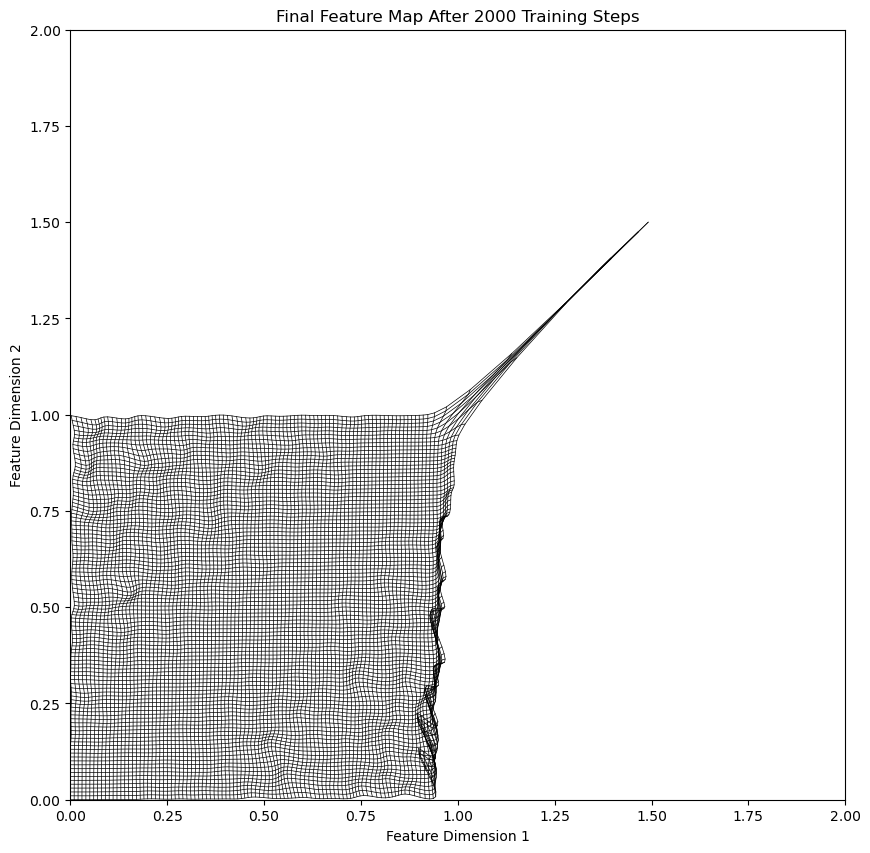

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# =========================
# Step 1: Define Parameters
# =========================
nn = 100  # Grid size (100 seems to matche Fig 8.5 resolution)
lr = 0.005  # Fixed learning rate (as in original)
sig = 2  # Fixed neighborhood width (as in original)
sig2 = 1 / (2 * sig**2)  # Precomputed factor for Gaussian
ntrial = 2000  # Total training steps (1000 before shift, 1000 after)

# Create a meshgrid for computing neighborhood function
x, y = np.meshgrid(np.arange(0, nn), np.arange(0, nn))

# ====================================================
# Step 2: Initialize Feature Map as a Structured Grid
# ====================================================
# c1 = np.zeros((nn, nn))
# c2 = np.zeros((nn, nn))

# oh wow -- the rounding errors due to division lead to some correlation 
# that leads the map to creep toward the identity axis
# for i in range(nn):
#     for j in range(nn):
#         c1[i, j] = i / nn  # x-coordinates: normalized row indices
#         c2[i, j] = j / nn  # y-coordinates: normalized column indices

# this removes rounding errors and makes it more stable. 
c1 = np.linspace(0, 1, nn).reshape(nn, 1) + np.zeros((1, nn))
c2 = np.linspace(0, 1, nn).reshape(1, nn) + np.zeros((nn, 1))

# 
# noise_strength = 0.02  # Adjust for more or less randomness
# c1 = np.linspace(0, 1, nn).reshape(nn, 1) + noise_strength * np.random.randn(nn, nn)
# c2 = np.linspace(0, 1, nn).reshape(1, nn) + noise_strength * np.random.randn(nn, nn)

# or make them random
# c1 = np.random.rand(nn, nn)  # Random values between 0 and 1
# c2 = np.random.rand(nn, nn)  # Random values between 0 and 1


# ====================================================
# Step 3: Training Session with shift after 1000 steps
# ====================================================
pshift = 0.5
for trial in range(ntrial):
    # Change input sampling after 1000 steps
    if trial < 1000:
        # r_in = np.random.rand(2)  # Training in [0,1] × [0,1]
        r_in = [np.random.uniform(0, 1), np.random.uniform(0, 1.5)]  # Unbalanced distribution

    else:
        if np.random.rand() < pshift:  # 50% chance: Original input region
            r_in = np.random.rand(2)
        else:  # 50% chance: Expanded feature space
            r_in = [np.random.uniform(1, 2), np.random.uniform(1, 2)]

    # Compute activation based on input proximity (Gaussian response)
    r = np.exp(-((c1 - r_in[0])**2 + (c2 - r_in[1])**2))

    # Find the winning neuron (closest match)
    winner = np.unravel_index(np.argmax(r, axis=None), r.shape)

    # Compute neighborhood function based on winner position
    r = np.exp(-((x - winner[0])**2 + (y - winner[1])**2) * sig2)

    # Update feature maps using the learning rule
    c1 += lr * r * (r_in[0] - c1)
    c2 += lr * r * (r_in[1] - c2)

    # =========================
    # Visualization
    # =========================
    if trial % 20 == 0:  # Update plot every 50 steps
        clear_output(wait=True)  # Clear previous output to avoid new figures
        plt.figure(figsize=(10, 10))
        plt.axis([0, 2, 0, 2])  # Expanded limits to accommodate new range
        plt.plot(c1, c2, 'k', linewidth=0.5)  # Plot horizontal connections
        plt.plot(c1.T, c2.T, 'k', linewidth=0.5)  # Plot vertical connections
        plt.xlabel("Feature Dimension 1")
        plt.ylabel("Feature Dimension 2")
        plt.title(f"Training Step: {trial}")
        display(plt.gcf())  # Display the updated figure
        plt.close()  # Prevent Jupyter from keeping multiple figures

# =========================
# Step 4: Final Plot After Training Ends
# =========================
clear_output(wait=True)  # Ensure only one final plot remains
plt.figure(figsize=(10, 10))
plt.axis([0, 2, 0, 2])  # Expanded limits to accommodate the shift
plt.plot(c1, c2, 'k', linewidth=0.5)  # Plot final feature grid (horizontal)
plt.plot(c1.T, c2.T, 'k', linewidth=0.5)  # Plot final feature grid (vertical)
plt.xlabel("Feature Dimension 1")
plt.ylabel("Feature Dimension 2")
plt.title(f"Final Feature Map After {ntrial} Training Steps")
plt.show()  # Display the final plot


## Note
This simulation is very sensitive to initial parameters. Explore changing the number of nodes, for example. Setting number of nodes to a large number reveals some oddities. I don't think it's worth it trying to make this simulation super robust; it serves the basic purpose of demonstrating change. If anyone has suggestions for other SOM ideas, I will try to develop a better example for the future. 

# Lab question (SOM): 

Can you explain what is going on in this simulation, and why there is a dramatic change after 1000 steps? What are some examples of feature dimensions that might be represented like this in the brain? 

